In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np

np.random.seed(123)

In [ ]:
data= pd.read_csv("/content/drive/MyDrive/AML coursework/Amazon_review.csv")
data = data[~data['text'].isna()]
data.head()


,review_id,text,verified,review_score,product_category
0,product_review_000000,Works great!. A Decent Condenser Mic,False,5.0,musical_instruments
1,product_review_000001,All these other posts about DRM this and DRM t...,False,1.0,video_games
2,product_review_000002,Great looking strings on my black classical gu...,True,5.0,musical_instruments
3,product_review_000003,I know people rant and rave about this game li...,True,2.0,video_games
4,product_review_000004,these things are great! just takes some time t...,True,5.0,video_games


In [ ]:
review_data = data[['text','review_score']]
review_data.head()

,text,review_score
0,Works great!. A Decent Condenser Mic,5.0
1,All these other posts about DRM this and DRM t...,1.0
2,Great looking strings on my black classical gu...,5.0
3,I know people rant and rave about this game li...,2.0
4,these things are great! just takes some time t...,5.0


In [ ]:
review_train_data = review_data[review_data['review_score']!=-1.]
r_texts_train = review_train_data['text'].values
r_labels_train = review_train_data['review_score'].values

In [ ]:
product_data = data[['text','product_category']]
print(product_data.head())

                                                text     product_category
0               Works great!. A Decent Condenser Mic  musical_instruments
1  All these other posts about DRM this and DRM t...          video_games
2  Great looking strings on my black classical gu...  musical_instruments
3  I know people rant and rave about this game li...          video_games
4  these things are great! just takes some time t...          video_games


In [ ]:
product_train_data = product_data[~product_data['product_category'].isna()]
p_texts_train = product_train_data['text'].values
p_labels_train = product_train_data['product_category'].values

In [ ]:
product_train_data.isna().sum()

text                0
product_category    0
dtype: int64

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score

In [ ]:
from tqdm import tqdm
def preprocess_text(text_data):

  data = [x.lower() for x in text_data]
  data = [word_tokenize(entry) for entry in data]

  tag_map = defaultdict(lambda : wn.NOUN)
  tag_map['J'] = wn.ADJ
  tag_map['V'] = wn.VERB
  tag_map['R'] = wn.ADV
  for index,entry in tqdm(enumerate(data),desc = "Processing text"):
    final_words = []
    word_lemmatized = WordNetLemmatizer()
    for word, tag in pos_tag(entry):
      if word not in stopwords.words('english') and word.isalpha():
        word_final = word_lemmatized.lemmatize(word,tag_map[tag[0]])
        final_words.append(word_final)
    data[index] = final_words
  data = [" ".join(sentence) for sentence in data]
  return data


In [ ]:
product_X_train = preprocess_text(p_texts_train)
review_X_train = preprocess_text(r_texts_train)

Processing text: 31998it [16:56, 31.49it/s]
Processing text: 31997it [15:12, 35.07it/s]


In [ ]:
import pickle
pickle.dump(product_X_train,open("review_X_train_processed",'wb'))
pickle.dump(review_X_train,open("product_X_train_processed",'wb'))

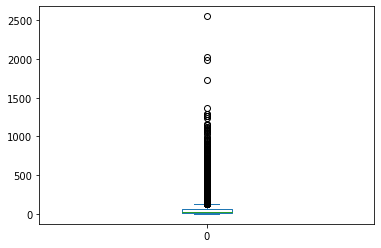

In [ ]:
#vectorize words
from tensorflow.keras.preprocessing.text import Tokenizer
from  tensorflow.keras.preprocessing import sequence

voc_size = 5000
max_len = 128
tok = Tokenizer(num_words=voc_size)
tok.fit_on_texts(review_X_train)
sequences = tok.texts_to_sequences(product_X_train)
seq_lens = pd.DataFrame([len(s) for s in sequences])
seq_lens.plot(kind='box').set(title="Visualizing distribution of length of sentences")
prod_sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)
sequences = tok.texts_to_sequences(review_X_train)
rev_sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [ ]:
prod_sequences_matrix.shape

(31998, 128)

In [ ]:
#onehotencode labels
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

p_le = LabelEncoder()
p_encoded_labels = p_le.fit_transform(p_labels_train)
p_labels_vec = to_categorical(p_encoded_labels)
r_le = LabelEncoder()
r_encoded_labels = r_le.fit_transform(r_labels_train)
r_labels_vec = to_categorical(r_encoded_labels)

In [ ]:
p_labels_vec.shape

(31998, 2)

In [ ]:

def model(input_shape,n_classes,loss='binary_crossentropy'):


  model=tf.keras.Sequential()

  model.add(tf.keras.layers.Embedding(voc_size,45,input_length=128))

  model.add(tf.compat.v1.keras.layers.CuDNNLSTM(128,input_shape=(input_shape),return_sequences=True))

  model.add(tf.keras.layers.Dropout(0.2))

  model.add(tf.compat.v1.keras.layers.CuDNNLSTM(128))

  model.add(tf.keras.layers.Dropout(0.2))

  # for units in [128,128,64,32]:

  # model.add(Dense(units,activation='relu'))

  # model.add(Dropout(0.2))

  model.add(tf.keras.layers.Dense(32,activation='sigmoid'))

  model.add(tf.keras.layers.Dropout(0.2))

  model.add(tf.keras.layers.Dense(n_classes,activation='softmax'))

  model.compile(loss=loss,optimizer='adam',metrics=['accuracy'])

  return model

In [ ]:
prod_model = model(prod_sequences_matrix.shape,p_labels_vec.shape[1])
prod_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 128, 45)           225000    
                                                                 
 cu_dnnlstm_7 (CuDNNLSTM)    (None, 128, 128)          89600     
                                                                 
 dropout_9 (Dropout)         (None, 128, 128)          0         
                                                                 
 cu_dnnlstm_8 (CuDNNLSTM)    (None, 128)               132096    
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 32)                4128      
                                                                 
 dropout_11 (Dropout)        (None, 32)               

In [ ]:
p_labels_vec.shape

NameError: ignored

In [ ]:
r_labels_vec.shape

(31997, 5)

In [ ]:
rev_model = model(rev_sequences_matrix.shape,r_labels_vec.shape[1],loss='categorical_crossentropy')
rev_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 128, 45)           225000    
                                                                 
 cu_dnnlstm_11 (CuDNNLSTM)   (None, 128, 128)          89600     
                                                                 
 dropout_15 (Dropout)        (None, 128, 128)          0         
                                                                 
 cu_dnnlstm_12 (CuDNNLSTM)   (None, 128)               132096    
                                                                 
 dropout_16 (Dropout)        (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 32)                4128      
                                                                 
 dropout_17 (Dropout)        (None, 32)               

In [ ]:
from sklearn.model_selection import train_test_split
p_X_train, p_X_test, p_y_train, p_y_test = train_test_split(prod_sequences_matrix, p_labels_vec, test_size=0.1, random_state=42,stratify=p_labels_vec)
r_X_train, r_X_test, r_y_train, r_y_test = train_test_split(rev_sequences_matrix, r_labels_vec, test_size=0.1, random_state=42,stratify=r_labels_vec)

In [ ]:
prod_model.fit(p_X_train,p_y_train,validation_data=(p_X_test,p_y_test),epochs=10,batch_size=128)

Epoch 1/10
225/225 [==============================] - 45s 69ms/step - loss: 0.5554 - accuracy: 0.7232 - val_loss: 0.2684 - val_accuracy: 0.8900
Epoch 2/10
225/225 [==============================] - 15s 65ms/step - loss: 0.2244 - accuracy: 0.9137 - val_loss: 0.1746 - val_accuracy: 0.9272
Epoch 3/10
225/225 [==============================] - 15s 65ms/step - loss: 0.1509 - accuracy: 0.9399 - val_loss: 0.1478 - val_accuracy: 0.9378
Epoch 4/10
225/225 [==============================] - 15s 64ms/step - loss: 0.1275 - accuracy: 0.9472 - val_loss: 0.1409 - val_accuracy: 0.9428
Epoch 5/10
225/225 [==============================] - 14s 64ms/step - loss: 0.1289 - accuracy: 0.9494 - val_loss: 0.1533 - val_accuracy: 0.9381
Epoch 6/10
225/225 [==============================] - 15s 65ms/step - loss: 0.1052 - accuracy: 0.9554 - val_loss: 0.1493 - val_accuracy: 0.9397
Epoch 7/10
225/225 [==============================] - 15s 65ms/step - loss: 0.0988 - accuracy: 0.9575 - val_loss: 0.1567 - val_accuracy:

In [ ]:
rev_model.fit(r_X_train,r_y_train,validation_data=(r_X_test,r_y_test),epochs=20,batch_size=128)

Epoch 1/20
225/225 [==============================] - 18s 68ms/step - loss: 1.0722 - accuracy: 0.6050 - val_loss: 0.9467 - val_accuracy: 0.6294
Epoch 2/20
225/225 [==============================] - 15s 65ms/step - loss: 0.9096 - accuracy: 0.6437 - val_loss: 0.9209 - val_accuracy: 0.6400
Epoch 3/20
225/225 [==============================] - 14s 64ms/step - loss: 0.8667 - accuracy: 0.6555 - val_loss: 0.9057 - val_accuracy: 0.6450
Epoch 4/20
225/225 [==============================] - 14s 64ms/step - loss: 0.8292 - accuracy: 0.6733 - val_loss: 0.8878 - val_accuracy: 0.6619
Epoch 5/20
225/225 [==============================] - 15s 66ms/step - loss: 0.7743 - accuracy: 0.6972 - val_loss: 0.8917 - val_accuracy: 0.6609
Epoch 6/20
225/225 [==============================] - 14s 64ms/step - loss: 0.7347 - accuracy: 0.7171 - val_loss: 0.8975 - val_accuracy: 0.6684
Epoch 7/20
225/225 [==============================] - 15s 66ms/step - loss: 0.6934 - accuracy: 0.7357 - val_loss: 0.9340 - val_accuracy:

array(["This controller the bittons had to be mashed so hard it hurt.... which isn't possible when playing something like the mario games. Didnt work",
       'Quick Shipment, Excellent Product. Thank You',
       'Great story, great gameplay and tones of replay ability. it took me about two weeks to pass the hole campaign along with all the side quests. longest story driven game i have played.. lots of replay ability',
       'they work pretty good so far. i have had no training on drums what so ever..im a guitar player  or keys.on ps3...the drums are the hardest to get use to because my left hand is not use to being used in this manor...but it works.they do what they are suppose to. im still working on learning to play..great set A+. drums'],
      dtype=object)

In [ ]:
product_example_data = product_data[~product_data['product_category'].isna()]
prod_examples =  product_example_data['text'].sample(10,random_state=45).to_numpy()
prod_examples_processed = preprocess_text(prod_examples)
prod_examples_seq = tok.texts_to_sequences(prod_examples_processed)
prod_examples_seq = sequence.pad_sequences(prod_examples_seq,maxlen=max_len)

Processing text: 10it [00:00, 10.53it/s]


In [ ]:
review_example_data = review_data[review_data['review_score']==-1.]
review_examples = review_example_data['text'].sample(10,random_state=45).to_numpy()
# preproces
review_examples_processed = preprocess_text(review_examples)
# vectorize
review_examples_seq = tok.texts_to_sequences(review_examples_processed)
review_examples_seq = sequence.pad_sequences(review_examples_seq,maxlen=max_len)


Processing text: 10it [00:00, 10.53it/s]


In [ ]:
y_hat = prod_model.predict(prod_examples_seq)
for x,y in zip(prod_examples,y_hat):
  print(x,p_le.inverse_transform([np.argmax(y)]))
  print("-------------------------")

This controller the bittons had to be mashed so hard it hurt.... which isn't possible when playing something like the mario games. Didnt work ['video_games']
-------------------------
Quick Shipment, Excellent Product. Thank You ['musical_instruments']
-------------------------
Great story, great gameplay and tones of replay ability. it took me about two weeks to pass the hole campaign along with all the side quests. longest story driven game i have played.. lots of replay ability ['video_games']
-------------------------
they work pretty good so far. i have had no training on drums what so ever..im a guitar player  or keys.on ps3...the drums are the hardest to get use to because my left hand is not use to being used in this manor...but it works.they do what they are suppose to. im still working on learning to play..great set A+. drums ['musical_instruments']
-------------------------
Nice headsets and good audio quality, excellent and sturdy build and very comfortable.
The mic in a li

In [ ]:
y_hat = rev_model.predict(review_examples_seq)
for x,y in zip(prod_examples,y_hat):
  print(x,r_le.inverse_transform([np.argmax(y)]))
  print("-------------------------")

This controller the bittons had to be mashed so hard it hurt.... which isn't possible when playing something like the mario games. Didnt work [5.]
-------------------------
Quick Shipment, Excellent Product. Thank You [5.]
-------------------------
Great story, great gameplay and tones of replay ability. it took me about two weeks to pass the hole campaign along with all the side quests. longest story driven game i have played.. lots of replay ability [5.]
-------------------------
they work pretty good so far. i have had no training on drums what so ever..im a guitar player  or keys.on ps3...the drums are the hardest to get use to because my left hand is not use to being used in this manor...but it works.they do what they are suppose to. im still working on learning to play..great set A+. drums [5.]
-------------------------
Nice headsets and good audio quality, excellent and sturdy build and very comfortable.
The mic in a little bit tricky but have an average volume and is bendable.
